In [3]:
import duckdb
import pandas as pd
import os

# Load master dataset and remove specified columns
base_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data"
master_path = f"{base_path}/user_period_master_complete.parquet"
output_dir = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data"
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/user_ml_features.parquet"

con = duckdb.connect()
con.execute("PRAGMA memory_limit='8GB';")

print("🚀 Loading and cleaning master dataset...")

# Complete query with all features
query = f"""
WITH cleaned_data AS (
    SELECT 
        userId,
        period_start,
        * EXCLUDE (
            userId, period_start, period_end,
            currently_helpful_count, currently_not_helpful_count, needs_more_ratings_count,
            first_status_helpful_count, first_status_not_helpful_count, locked_notes_count,
            core_helpful_count, expansion_helpful_count, group_helpful_count,
            avg_hours_to_first_status
        )
    FROM read_parquet('{master_path}')
    WHERE period_start IS NOT NULL
    ORDER BY userId, period_start
),
time_series_data AS (
    SELECT 
        userId,
        period_start,
        ROW_NUMBER() OVER (PARTITION BY userId ORDER BY period_start) AS time_index,
        -- Core metrics
        total_notes_authored, total_ratings, helpful_ratio, not_misleading_count, misleading_count,
        avg_core_note_intercept, avg_core_note_factor1,
        -- Rating breakdown
        helpful_count, not_helpful_count,
        -- Helpful vs not helpful analysis
        avg_intercept_helpful, avg_intercept_not_helpful, avg_factor1_helpful, avg_factor1_not_helpful,
        -- Misleading tags
        avg_misleading_other, avg_misleading_factual_error, avg_misleading_manipulated_media,
        avg_misleading_outdated_info, avg_misleading_missing_context, avg_misleading_unverified_claim,
        avg_misleading_satire,
        -- Not misleading tags
        avg_not_misleading_other, avg_not_misleading_factually_correct,
        avg_not_misleading_outdated_but_not_when_written, avg_not_misleading_clearly_satire,
        avg_not_misleading_personal_opinion,
        -- Other features
        avg_trustworthy_sources, avg_is_media_note,
        -- Lag values
        LAG(total_notes_authored) OVER (PARTITION BY userId ORDER BY period_start) as prev_notes_authored,
        LAG(total_ratings) OVER (PARTITION BY userId ORDER BY period_start) as prev_total_ratings,
        LAG(helpful_ratio) OVER (PARTITION BY userId ORDER BY period_start) as prev_helpful_ratio,
        LAG(helpful_count) OVER (PARTITION BY userId ORDER BY period_start) as prev_helpful_count,
        LAG(not_helpful_count) OVER (PARTITION BY userId ORDER BY period_start) as prev_not_helpful_count
    FROM cleaned_data
),
user_aggregates AS (
    SELECT
        userId,
        COUNT(*) as num_periods,
        
        -- Core metrics aggregation
        AVG(total_notes_authored) as mean_notes_authored,
        STDDEV(total_notes_authored) as std_notes_authored,
        MIN(total_notes_authored) as min_notes_authored,
        MAX(total_notes_authored) as max_notes_authored,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_notes_authored) as median_notes_authored,
        
        AVG(total_ratings) as mean_total_ratings,
        STDDEV(total_ratings) as std_total_ratings,
        MIN(total_ratings) as min_total_ratings,
        MAX(total_ratings) as max_total_ratings,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_ratings) as median_total_ratings,
        
        AVG(helpful_ratio) as mean_helpful_ratio,
        STDDEV(helpful_ratio) as std_helpful_ratio,
        MIN(helpful_ratio) as min_helpful_ratio,
        MAX(helpful_ratio) as max_helpful_ratio,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY helpful_ratio) as median_helpful_ratio,
        
        -- Helpful/Not helpful counts
        AVG(helpful_count) as mean_helpful_count,
        STDDEV(helpful_count) as std_helpful_count,
        MIN(helpful_count) as min_helpful_count,
        MAX(helpful_count) as max_helpful_count,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY helpful_count) as median_helpful_count,
        
        AVG(not_helpful_count) as mean_not_helpful_count,
        STDDEV(not_helpful_count) as std_not_helpful_count,
        MIN(not_helpful_count) as min_not_helpful_count,
        MAX(not_helpful_count) as max_not_helpful_count,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY not_helpful_count) as median_not_helpful_count,
        
        -- Misleading analysis
        AVG(not_misleading_count) as mean_not_misleading,
        STDDEV(not_misleading_count) as std_not_misleading,
        MIN(not_misleading_count) as min_not_misleading,
        MAX(not_misleading_count) as max_not_misleading,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY not_misleading_count) as median_not_misleading,
        
        AVG(misleading_count) as mean_misleading,
        STDDEV(misleading_count) as std_misleading,
        MIN(misleading_count) as min_misleading,
        MAX(misleading_count) as max_misleading,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY misleading_count) as median_misleading,
        
        -- Core note scores
        AVG(avg_core_note_intercept) as mean_intercept,
        STDDEV(avg_core_note_intercept) as std_intercept,
        MIN(avg_core_note_intercept) as min_intercept,
        MAX(avg_core_note_intercept) as max_intercept,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_core_note_intercept) as median_intercept,
        
        AVG(avg_core_note_factor1) as mean_factor1,
        STDDEV(avg_core_note_factor1) as std_factor1,
        MIN(avg_core_note_factor1) as min_factor1,
        MAX(avg_core_note_factor1) as max_factor1,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_core_note_factor1) as median_factor1,
        
        -- Helpful vs not helpful intercept/factor analysis
        AVG(avg_intercept_helpful) as mean_intercept_helpful,
        STDDEV(avg_intercept_helpful) as std_intercept_helpful,
        MIN(avg_intercept_helpful) as min_intercept_helpful,
        MAX(avg_intercept_helpful) as max_intercept_helpful,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_intercept_helpful) as median_intercept_helpful,
        
        AVG(avg_intercept_not_helpful) as mean_intercept_not_helpful,
        STDDEV(avg_intercept_not_helpful) as std_intercept_not_helpful,
        MIN(avg_intercept_not_helpful) as min_intercept_not_helpful,
        MAX(avg_intercept_not_helpful) as max_intercept_not_helpful,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_intercept_not_helpful) as median_intercept_not_helpful,
        
        AVG(avg_factor1_helpful) as mean_factor1_helpful,
        STDDEV(avg_factor1_helpful) as std_factor1_helpful,
        MIN(avg_factor1_helpful) as min_factor1_helpful,
        MAX(avg_factor1_helpful) as max_factor1_helpful,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_factor1_helpful) as median_factor1_helpful,
        
        AVG(avg_factor1_not_helpful) as mean_factor1_not_helpful,
        STDDEV(avg_factor1_not_helpful) as std_factor1_not_helpful,
        MIN(avg_factor1_not_helpful) as min_factor1_not_helpful,
        MAX(avg_factor1_not_helpful) as max_factor1_not_helpful,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_factor1_not_helpful) as median_factor1_not_helpful,
        
        -- Misleading tag averages
        AVG(avg_misleading_other) as mean_misleading_other,
        STDDEV(avg_misleading_other) as std_misleading_other,
        MIN(avg_misleading_other) as min_misleading_other,
        MAX(avg_misleading_other) as max_misleading_other,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_other) as median_misleading_other,
        
        AVG(avg_misleading_factual_error) as mean_misleading_factual_error,
        STDDEV(avg_misleading_factual_error) as std_misleading_factual_error,
        MIN(avg_misleading_factual_error) as min_misleading_factual_error,
        MAX(avg_misleading_factual_error) as max_misleading_factual_error,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_factual_error) as median_misleading_factual_error,
        
        AVG(avg_misleading_manipulated_media) as mean_misleading_manipulated_media,
        STDDEV(avg_misleading_manipulated_media) as std_misleading_manipulated_media,
        MIN(avg_misleading_manipulated_media) as min_misleading_manipulated_media,
        MAX(avg_misleading_manipulated_media) as max_misleading_manipulated_media,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_manipulated_media) as median_misleading_manipulated_media,
        
        AVG(avg_misleading_outdated_info) as mean_misleading_outdated_info,
        STDDEV(avg_misleading_outdated_info) as std_misleading_outdated_info,
        MIN(avg_misleading_outdated_info) as min_misleading_outdated_info,
        MAX(avg_misleading_outdated_info) as max_misleading_outdated_info,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_outdated_info) as median_misleading_outdated_info,
        
        AVG(avg_misleading_missing_context) as mean_misleading_missing_context,
        STDDEV(avg_misleading_missing_context) as std_misleading_missing_context,
        MIN(avg_misleading_missing_context) as min_misleading_missing_context,
        MAX(avg_misleading_missing_context) as max_misleading_missing_context,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_missing_context) as median_misleading_missing_context,
        
        AVG(avg_misleading_unverified_claim) as mean_misleading_unverified_claim,
        STDDEV(avg_misleading_unverified_claim) as std_misleading_unverified_claim,
        MIN(avg_misleading_unverified_claim) as min_misleading_unverified_claim,
        MAX(avg_misleading_unverified_claim) as max_misleading_unverified_claim,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_unverified_claim) as median_misleading_unverified_claim,
        
        AVG(avg_misleading_satire) as mean_misleading_satire,
        STDDEV(avg_misleading_satire) as std_misleading_satire,
        MIN(avg_misleading_satire) as min_misleading_satire,
        MAX(avg_misleading_satire) as max_misleading_satire,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_misleading_satire) as median_misleading_satire,
        
        -- Not misleading tag averages
        AVG(avg_not_misleading_other) as mean_not_misleading_other,
        STDDEV(avg_not_misleading_other) as std_not_misleading_other,
        MIN(avg_not_misleading_other) as min_not_misleading_other,
        MAX(avg_not_misleading_other) as max_not_misleading_other,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_not_misleading_other) as median_not_misleading_other,
        
        AVG(avg_not_misleading_factually_correct) as mean_not_misleading_factually_correct,
        STDDEV(avg_not_misleading_factually_correct) as std_not_misleading_factually_correct,
        MIN(avg_not_misleading_factually_correct) as min_not_misleading_factually_correct,
        MAX(avg_not_misleading_factually_correct) as max_not_misleading_factually_correct,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_not_misleading_factually_correct) as median_not_misleading_factually_correct,
        
        AVG(avg_not_misleading_outdated_but_not_when_written) as mean_not_misleading_outdated_but_not_when_written,
        STDDEV(avg_not_misleading_outdated_but_not_when_written) as std_not_misleading_outdated_but_not_when_written,
        MIN(avg_not_misleading_outdated_but_not_when_written) as min_not_misleading_outdated_but_not_when_written,
        MAX(avg_not_misleading_outdated_but_not_when_written) as max_not_misleading_outdated_but_not_when_written,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_not_misleading_outdated_but_not_when_written) as median_not_misleading_outdated_but_not_when_written,
        
        AVG(avg_not_misleading_clearly_satire) as mean_not_misleading_clearly_satire,
        STDDEV(avg_not_misleading_clearly_satire) as std_not_misleading_clearly_satire,
        MIN(avg_not_misleading_clearly_satire) as min_not_misleading_clearly_satire,
        MAX(avg_not_misleading_clearly_satire) as max_not_misleading_clearly_satire,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_not_misleading_clearly_satire) as median_not_misleading_clearly_satire,
        
        AVG(avg_not_misleading_personal_opinion) as mean_not_misleading_personal_opinion,
        STDDEV(avg_not_misleading_personal_opinion) as std_not_misleading_personal_opinion,
        MIN(avg_not_misleading_personal_opinion) as min_not_misleading_personal_opinion,
        MAX(avg_not_misleading_personal_opinion) as max_not_misleading_personal_opinion,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_not_misleading_personal_opinion) as median_not_misleading_personal_opinion,
        
        -- Additional features
        AVG(avg_trustworthy_sources) as mean_trustworthy_sources,
        STDDEV(avg_trustworthy_sources) as std_trustworthy_sources,
        MIN(avg_trustworthy_sources) as min_trustworthy_sources,
        MAX(avg_trustworthy_sources) as max_trustworthy_sources,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_trustworthy_sources) as median_trustworthy_sources,
        
        AVG(avg_is_media_note) as mean_is_media_note,
        STDDEV(avg_is_media_note) as std_is_media_note,
        MIN(avg_is_media_note) as min_is_media_note,
        MAX(avg_is_media_note) as max_is_media_note,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY avg_is_media_note) as median_is_media_note,
        
        -- Change counts
        SUM(CASE WHEN total_notes_authored > prev_notes_authored THEN 1 ELSE 0 END) as pos_changes_notes,
        SUM(CASE WHEN total_notes_authored < prev_notes_authored THEN 1 ELSE 0 END) as neg_changes_notes,
        SUM(CASE WHEN total_ratings > prev_total_ratings THEN 1 ELSE 0 END) as pos_changes_ratings,
        SUM(CASE WHEN total_ratings < prev_total_ratings THEN 1 ELSE 0 END) as neg_changes_ratings,
        SUM(CASE WHEN helpful_ratio > prev_helpful_ratio THEN 1 ELSE 0 END) as pos_changes_helpful_ratio,
        SUM(CASE WHEN helpful_ratio < prev_helpful_ratio THEN 1 ELSE 0 END) as neg_changes_helpful_ratio,
        SUM(CASE WHEN helpful_count > prev_helpful_count THEN 1 ELSE 0 END) as pos_changes_helpful_count,
        SUM(CASE WHEN helpful_count < prev_helpful_count THEN 1 ELSE 0 END) as neg_changes_helpful_count,
        SUM(CASE WHEN not_helpful_count > prev_not_helpful_count THEN 1 ELSE 0 END) as pos_changes_not_helpful_count,
        SUM(CASE WHEN not_helpful_count < prev_not_helpful_count THEN 1 ELSE 0 END) as neg_changes_not_helpful_count,
        
        -- Linear regression slopes
        REGR_SLOPE(total_notes_authored, time_index) as slope_notes_authored,
        REGR_SLOPE(total_ratings, time_index) as slope_total_ratings,
        REGR_SLOPE(helpful_ratio, time_index) as slope_helpful_ratio,
        REGR_SLOPE(helpful_count, time_index) as slope_helpful_count,
        REGR_SLOPE(not_helpful_count, time_index) as slope_not_helpful_count,
        REGR_SLOPE(not_misleading_count, time_index) as slope_not_misleading,
        REGR_SLOPE(misleading_count, time_index) as slope_misleading,
        REGR_SLOPE(avg_core_note_intercept, time_index) as slope_intercept,
        REGR_SLOPE(avg_core_note_factor1, time_index) as slope_factor1,
        REGR_SLOPE(avg_intercept_helpful, time_index) as slope_intercept_helpful,
        REGR_SLOPE(avg_intercept_not_helpful, time_index) as slope_intercept_not_helpful,
        REGR_SLOPE(avg_factor1_helpful, time_index) as slope_factor1_helpful,
        REGR_SLOPE(avg_factor1_not_helpful, time_index) as slope_factor1_not_helpful
        
    FROM time_series_data
    GROUP BY userId
    HAVING COUNT(*) >= 3
)
SELECT * FROM user_aggregates
ORDER BY userId
"""

# Execute and save results
con.execute(f"COPY ({query}) TO '{output_path}' (FORMAT PARQUET);")

# Preview results
print("\n📊 User aggregation complete!")
preview = con.execute(f"SELECT * FROM '{output_path}' LIMIT 5").fetchdf()
print(f"Shape: {len(con.execute(f'SELECT * FROM \'{output_path}\'').fetchdf())} users × {len(preview.columns)} features")
print(preview)

con.close()
print(f"\n✅ Saved to: {output_path}")

🚀 Loading and cleaning master dataset...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


📊 User aggregation complete!


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Shape: 1096540 users × 160 features
                                              userId  num_periods  \
0  0000010BB832A9CFDF102BF7B66896FA987C80FBB61EF6...            3   
1  000011269AD6F327AED0F4086A732B4052F9D28E8791E1...           38   
2  00002C7FD6E0080A69D0AB879C3D9BB704BEFCC078AD40...           30   
3  0000315D36021A528D85155729DDBF2E299BB8C3040878...           10   
4  00003B703F86036C51F4F4B4C9F77B00C92D882421DA73...           17   

   mean_notes_authored  std_notes_authored  min_notes_authored  \
0                  NaN                 NaN                <NA>   
1                  NaN                 NaN                <NA>   
2                  NaN                 NaN                <NA>   
3                  NaN                 NaN                <NA>   
4                  NaN                 NaN                <NA>   

   max_notes_authored  median_notes_authored  mean_total_ratings  \
0                <NA>                    NaN            3.333333   
1               

In [4]:
import duckdb
import pandas as pd

# Add target variable (internalRaterFactor1) to ML features dataset
ml_features_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data\user_ml_features.parquet"
factor_data_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\prescoringRaterModelOutput_3dim.tsv"
output_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data\user_ml_features_with_target.parquet"

con = duckdb.connect()
con.execute("PRAGMA memory_limit='8GB';")

print("🎯 Adding target variable (internalRaterFactor1)...")

# Join ML features with factor data to create target variable
query = f"""
COPY (
    SELECT 
        f.*,
        r.internalRaterFactor1 as target_factor1
    FROM read_parquet('{ml_features_path}') f
    LEFT JOIN read_csv('{factor_data_path}', sep='\t') r 
        ON f.userId = r.raterParticipantId
    ORDER BY f.userId
) TO '{output_path}' (FORMAT PARQUET);
"""

con.execute(query)

# Check results
stats = con.execute(f"""
    SELECT 
        COUNT(*) as total_users,
        COUNT(target_factor1) as users_with_target,
        ROUND(COUNT(target_factor1) * 100.0 / COUNT(*), 1) as pct_with_target,
        ROUND(MIN(target_factor1), 3) as min_target,
        ROUND(MAX(target_factor1), 3) as max_target,
        ROUND(AVG(target_factor1), 3) as avg_target
    FROM '{output_path}'
""").fetchdf()

print("📊 Target Variable Statistics:")
print(stats.to_string(index=False))

# Preview
preview = con.execute(f"""
    SELECT userId, num_periods, mean_total_ratings, mean_helpful_ratio, target_factor1
    FROM '{output_path}' 
    LIMIT 10
""").fetchdf()
print("\n📝 Preview:")
print(preview.to_string(index=False))

con.close()
print(f"\n✅ ML dataset with target saved to: {output_path}")

🎯 Adding target variable (internalRaterFactor1)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📊 Target Variable Statistics:
 total_users  users_with_target  pct_with_target  min_target  max_target  avg_target
     1096540             196645             17.9      -1.515       0.833      -0.329

📝 Preview:
                                                          userId  num_periods  mean_total_ratings  mean_helpful_ratio  target_factor1
0000010BB832A9CFDF102BF7B66896FA987C80FBB61EF6C4B04D875B85C07BD8            3            3.333333            0.916667             NaN
000011269AD6F327AED0F4086A732B4052F9D28E8791E117DC07497FF7CFB18C           38           12.578947            0.769529             NaN
00002C7FD6E0080A69D0AB879C3D9BB704BEFCC078AD400FA8258D4986630368           30            2.100000            0.950000             NaN
0000315D36021A528D85155729DDBF2E299BB8C304087899EEDACE7782CE8272           10            2.800000            0.850000       -0.029264
00003B703F86036C51F4F4B4C9F77B00C92D882421DA73214EE578AE06A2A7E8           17            3.235294            0.830753 

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Load the ML features with target
input_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data\user_ml_features_with_target.parquet"
output_dir = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data"

print("🔄 Loading ML dataset and preparing train/val/test splits...")

# Load data
df = pd.read_parquet(input_path)
print(f"Total dataset shape: {df.shape}")

# Separate labeled vs unlabeled data
labeled_data = df[df['target_factor1'].notna()].copy()
unlabeled_data = df[df['target_factor1'].isna()].copy()

print(f"Labeled data shape: {labeled_data.shape}")
print(f"Unlabeled data shape: {unlabeled_data.shape}")
print(f"Labeled percentage: {len(labeled_data)/len(df)*100:.1f}%")

# Prepare feature columns (exclude userId and target)
feature_cols = [col for col in df.columns if col not in ['userId', 'target_factor1']]
print(f"Number of features: {len(feature_cols)}")

# Extract features and target from labeled data
X_labeled = labeled_data[feature_cols].copy()
y_labeled = labeled_data['target_factor1'].copy()
labeled_user_ids = labeled_data['userId'].copy()

# Handle any remaining NaN values in features
print(f"NaN values before cleaning: {X_labeled.isnull().sum().sum()}")
X_labeled = X_labeled.fillna(0)  # Fill remaining NaNs with 0
print(f"NaN values after cleaning: {X_labeled.isnull().sum().sum()}")

# Split labeled data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(
    X_labeled, y_labeled, labeled_user_ids, 
    test_size=0.15, random_state=42, stratify=None
)

X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.176,  # 0.15/0.85 = 0.176 to get 15% of original
    random_state=42, stratify=None
)

print(f"\nData splits:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(labeled_data)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(labeled_data)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(labeled_data)*100:.1f}%)")

# Normalize features using StandardScaler
print("\n🔧 Normalizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Also scale unlabeled data for prediction
X_unlabeled = unlabeled_data[feature_cols].copy()
X_unlabeled = X_unlabeled.fillna(0)
X_unlabeled_scaled = scaler.transform(X_unlabeled)
unlabeled_user_ids = unlabeled_data['userId'].copy()

# Convert back to DataFrames for easier handling
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
X_unlabeled_df = pd.DataFrame(X_unlabeled_scaled, columns=feature_cols, index=X_unlabeled.index)

# Save all splits
print("\n💾 Saving normalized datasets...")

# Training set
train_data = pd.concat([
    ids_train.reset_index(drop=True),
    pd.DataFrame(X_train_scaled, columns=feature_cols),
    y_train.reset_index(drop=True)
], axis=1)
train_data.columns = ['userId'] + feature_cols + ['target_factor1']
train_data.to_parquet(f"{output_dir}/train_data.parquet", index=False)

# Validation set
val_data = pd.concat([
    ids_val.reset_index(drop=True),
    pd.DataFrame(X_val_scaled, columns=feature_cols),
    y_val.reset_index(drop=True)
], axis=1)
val_data.columns = ['userId'] + feature_cols + ['target_factor1']
val_data.to_parquet(f"{output_dir}/val_data.parquet", index=False)

# Test set
test_data = pd.concat([
    ids_test.reset_index(drop=True),
    pd.DataFrame(X_test_scaled, columns=feature_cols),
    y_test.reset_index(drop=True)
], axis=1)
test_data.columns = ['userId'] + feature_cols + ['target_factor1']
test_data.to_parquet(f"{output_dir}/test_data.parquet", index=False)

# Unlabeled set (for prediction)
unlabeled_data_scaled = pd.concat([
    unlabeled_user_ids.reset_index(drop=True),
    pd.DataFrame(X_unlabeled_scaled, columns=feature_cols)
], axis=1)
unlabeled_data_scaled.columns = ['userId'] + feature_cols
unlabeled_data_scaled.to_parquet(f"{output_dir}/unlabeled_data.parquet", index=False)

# Save the scaler for future use
joblib.dump(scaler, f"{output_dir}/feature_scaler.pkl")

# Save feature column names
with open(f"{output_dir}/feature_columns.txt", 'w') as f:
    for col in feature_cols:
        f.write(f"{col}\n")

print("\n📊 Dataset Statistics:")
print(f"Target variable (factor1) statistics:")
print(f"  Mean: {y_labeled.mean():.4f}")
print(f"  Std:  {y_labeled.std():.4f}")
print(f"  Min:  {y_labeled.min():.4f}")
print(f"  Max:  {y_labeled.max():.4f}")

print(f"\nTrain set target stats:")
print(f"  Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Val set target stats:")
print(f"  Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")
print(f"Test set target stats:")
print(f"  Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")

print(f"\n✅ Data preparation complete!")
print(f"📁 Files saved:")
print(f"  - train_data.parquet ({train_data.shape})")
print(f"  - val_data.parquet ({val_data.shape})")
print(f"  - test_data.parquet ({test_data.shape})")
print(f"  - unlabeled_data.parquet ({unlabeled_data_scaled.shape})")
print(f"  - feature_scaler.pkl")
print(f"  - feature_columns.txt")

🔄 Loading ML dataset and preparing train/val/test splits...
Total dataset shape: (1096540, 161)
Total dataset shape: (1096540, 161)
Labeled data shape: (196645, 161)
Unlabeled data shape: (899895, 161)
Labeled percentage: 17.9%
Number of features: 159
NaN values before cleaning: 11173048
Labeled data shape: (196645, 161)
Unlabeled data shape: (899895, 161)
Labeled percentage: 17.9%
Number of features: 159
NaN values before cleaning: 11173048
NaN values after cleaning: 0
NaN values after cleaning: 0

Data splits:
Training set: 137729 samples (70.0%)
Validation set: 29419 samples (15.0%)
Test set: 29497 samples (15.0%)

🔧 Normalizing features...

Data splits:
Training set: 137729 samples (70.0%)
Validation set: 29419 samples (15.0%)
Test set: 29497 samples (15.0%)

🔧 Normalizing features...

💾 Saving normalized datasets...

💾 Saving normalized datasets...

📊 Dataset Statistics:
Target variable (factor1) statistics:
  Mean: -0.3287
  Std:  0.2950
  Min:  -1.5152
  Max:  0.8332

Train set 

🔍 Performing PCA Analysis...
Training data shape: (137729, 161)
Number of features: 159

PCA Results:
Total components: 159
Components for 95% variance: 61
Components for 99% variance: 92

PCA Results:
Total components: 159
Components for 95% variance: 61
Components for 99% variance: 92


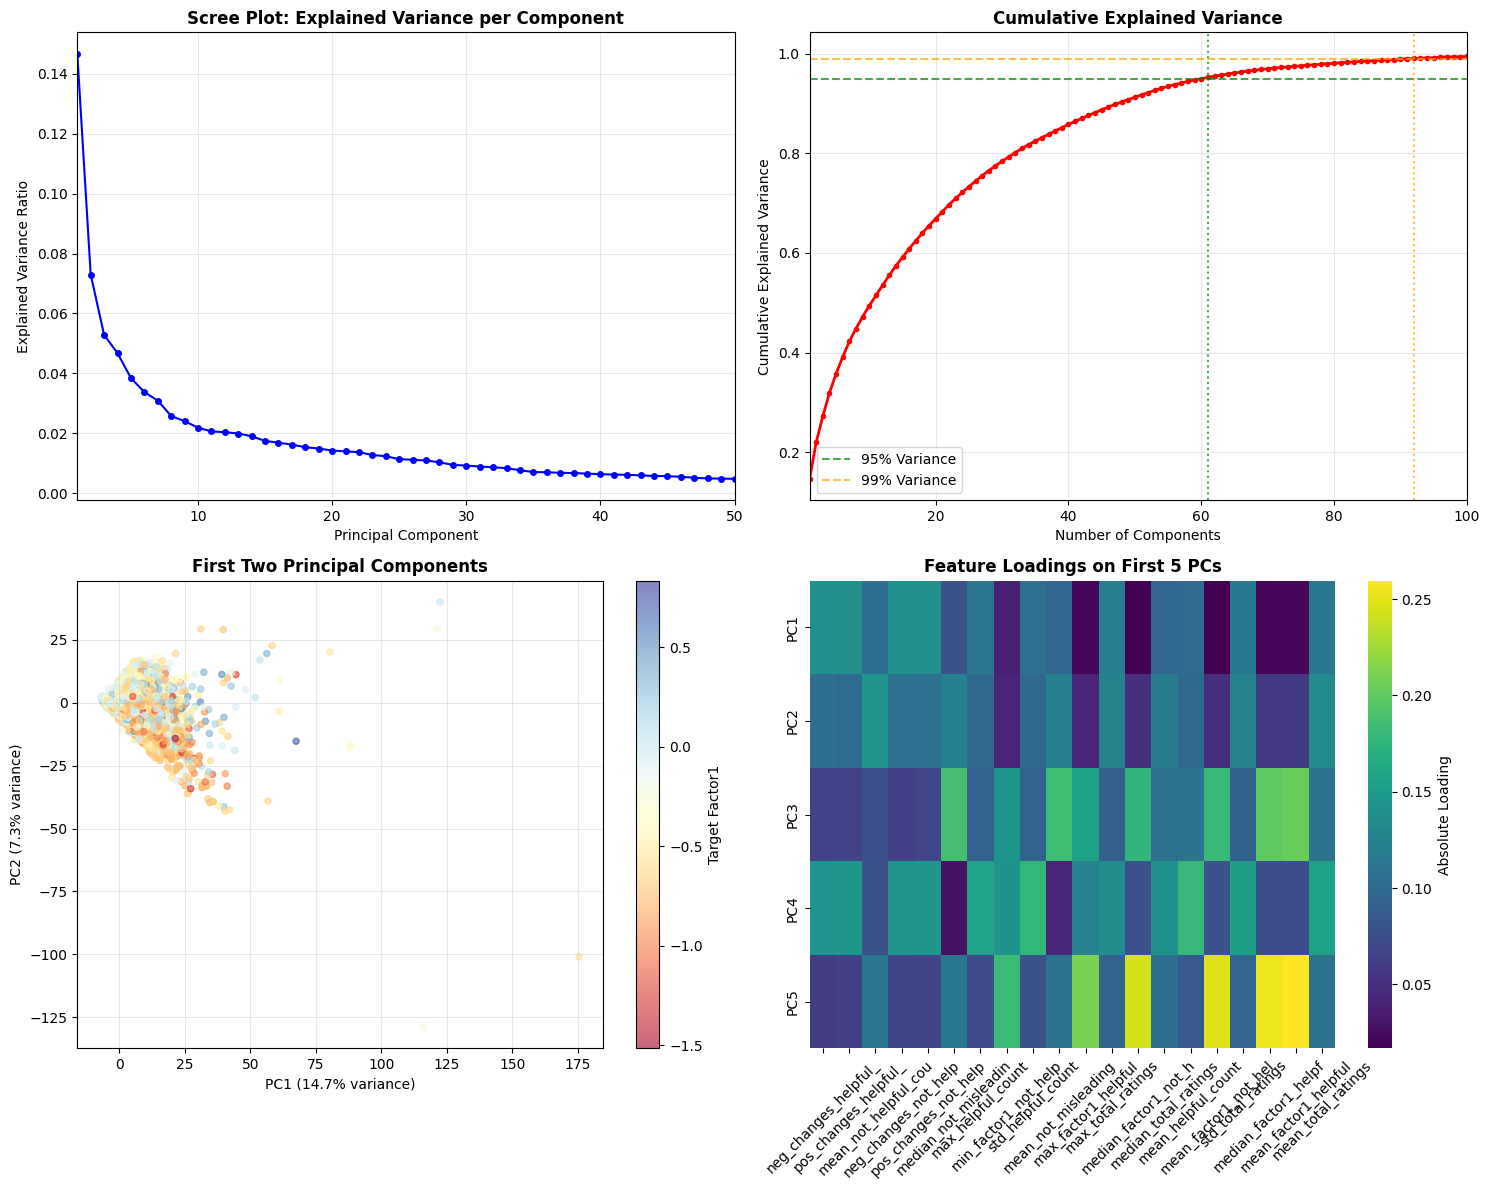


Detailed PCA Statistics:
Explained variance by first 10 components:
  PC1: 0.147 (14.7%)
  PC2: 0.073 (7.3%)
  PC3: 0.053 (5.3%)
  PC4: 0.047 (4.7%)
  PC5: 0.038 (3.8%)
  PC6: 0.034 (3.4%)
  PC7: 0.031 (3.1%)
  PC8: 0.026 (2.6%)
  PC9: 0.024 (2.4%)
  PC10: 0.022 (2.2%)

Cumulative variance explained:
  First 5 components: 0.358 (35.8%)
  First 10 components: 0.494 (49.4%)
  First 20 components: 0.669 (66.9%)

✅ PCA Analysis Complete!
📁 Saved files:
  - train_data_pca95.parquet ((137729, 63))
  - pca_model_95.pkl

Dimensionality reduction: 159 → 61 features (95% variance retained)

✅ PCA Analysis Complete!
📁 Saved files:
  - train_data_pca95.parquet ((137729, 63))
  - pca_model_95.pkl

Dimensionality reduction: 159 → 61 features (95% variance retained)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load the normalized training data
data_dir = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data"
train_data = pd.read_parquet(f"{data_dir}/train_data.parquet")

print("🔍 Performing PCA Analysis...")
print(f"Training data shape: {train_data.shape}")

# Separate features and target
feature_cols = [col for col in train_data.columns if col not in ['userId', 'target_factor1']]
X_train = train_data[feature_cols].values
y_train = train_data['target_factor1'].values

print(f"Number of features: {len(feature_cols)}")

# Perform PCA with all components
pca_full = PCA()
X_pca = pca_full.fit_transform(X_train)

# Calculate cumulative explained variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
n_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"\nPCA Results:")
print(f"Total components: {len(pca_full.explained_variance_ratio_)}")
print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree plot - explained variance per component
axes[0, 0].plot(range(1, min(51, len(pca_full.explained_variance_ratio_) + 1)), 
                pca_full.explained_variance_ratio_[:50], 'bo-', markersize=4, linewidth=1.5)
axes[0, 0].set_title('Scree Plot: Explained Variance per Component', fontweight='bold')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(1, min(50, len(pca_full.explained_variance_ratio_)))

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-', markersize=3, linewidth=2)
axes[0, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% Variance')
axes[0, 1].axhline(y=0.99, color='orange', linestyle='--', alpha=0.7, label='99% Variance')
axes[0, 1].axvline(x=n_95, color='green', linestyle=':', alpha=0.7)
axes[0, 1].axvline(x=n_99, color='orange', linestyle=':', alpha=0.7)
axes[0, 1].set_title('Cumulative Explained Variance', fontweight='bold')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(1, min(100, len(cumsum_variance)))

# 3. First two principal components scatter plot
scatter = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
                           cmap='RdYlBu', alpha=0.6, s=20)
axes[1, 0].set_title('First Two Principal Components', fontweight='bold')
axes[1, 0].set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, ax=axes[1, 0], label='Target Factor1')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature importance in first few components
n_components_show = min(5, len(pca_full.components_))
n_features_show = min(20, len(feature_cols))

# Get top features for first few components
component_importance = np.abs(pca_full.components_[:n_components_show, :])
top_features_idx = np.argsort(component_importance.sum(axis=0))[-n_features_show:]

# Create heatmap
sns.heatmap(component_importance[:, top_features_idx], 
           xticklabels=[feature_cols[i][:20] for i in top_features_idx],
           yticklabels=[f'PC{i+1}' for i in range(n_components_show)],
           cmap='viridis', ax=axes[1, 1], cbar_kws={'label': 'Absolute Loading'})
axes[1, 1].set_title('Feature Loadings on First 5 PCs', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nDetailed PCA Statistics:")
print(f"Explained variance by first 10 components:")
for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca_full.explained_variance_ratio_[i]:.3f} ({pca_full.explained_variance_ratio_[i]*100:.1f}%)")

print(f"\nCumulative variance explained:")
print(f"  First 5 components: {cumsum_variance[4]:.3f} ({cumsum_variance[4]*100:.1f}%)")
print(f"  First 10 components: {cumsum_variance[9]:.3f} ({cumsum_variance[9]*100:.1f}%)")
print(f"  First 20 components: {cumsum_variance[19]:.3f} ({cumsum_variance[19]*100:.1f}%)")

# Save PCA results for potential use in modeling
pca_95 = PCA(n_components=n_95)
X_pca_95 = pca_95.fit_transform(X_train)

# Save PCA-transformed training data
train_pca_data = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(n_95)])
train_pca_data['userId'] = train_data['userId'].values
train_pca_data['target_factor1'] = y_train
train_pca_data.to_parquet(f"{data_dir}/train_data_pca95.parquet", index=False)

# Save PCA model
import joblib
joblib.dump(pca_95, f"{data_dir}/pca_model_95.pkl")

print(f"\n✅ PCA Analysis Complete!")
print(f"📁 Saved files:")
print(f"  - train_data_pca95.parquet ({train_pca_data.shape})")
print(f"  - pca_model_95.pkl")
print(f"\nDimensionality reduction: {len(feature_cols)} → {n_95} features (95% variance retained)")

🚀 Training LightGBM model with iterative optimization...
Training data shape: (137729, 161)
Validation data shape: (29419, 161)
Test data shape: (29497, 161)
Number of features: 159
Target range: [-1.515, 0.833]

🔧 Training baseline model...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[772]	train's rmse: 0.157327	val's rmse: 0.191143
Baseline RMSE: 0.1911

🎯 Starting iterative hyperparameter optimization...

📊 Grid 1: Optimizing ['learning_rate', 'num_leaves', 'max_depth']
Early stopping, best iteration is:
[772]	train's rmse: 0.157327	val's rmse: 0.191143
Baseline RMSE: 0.1911

🎯 Starting iterative hyperparameter optimization...

📊 Grid 1: Optimizing ['learning_rate', 'num_leaves', 'max_depth']
Training until validation scores don't improve for 80 rounds
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1379]	val's rmse: 0.1902

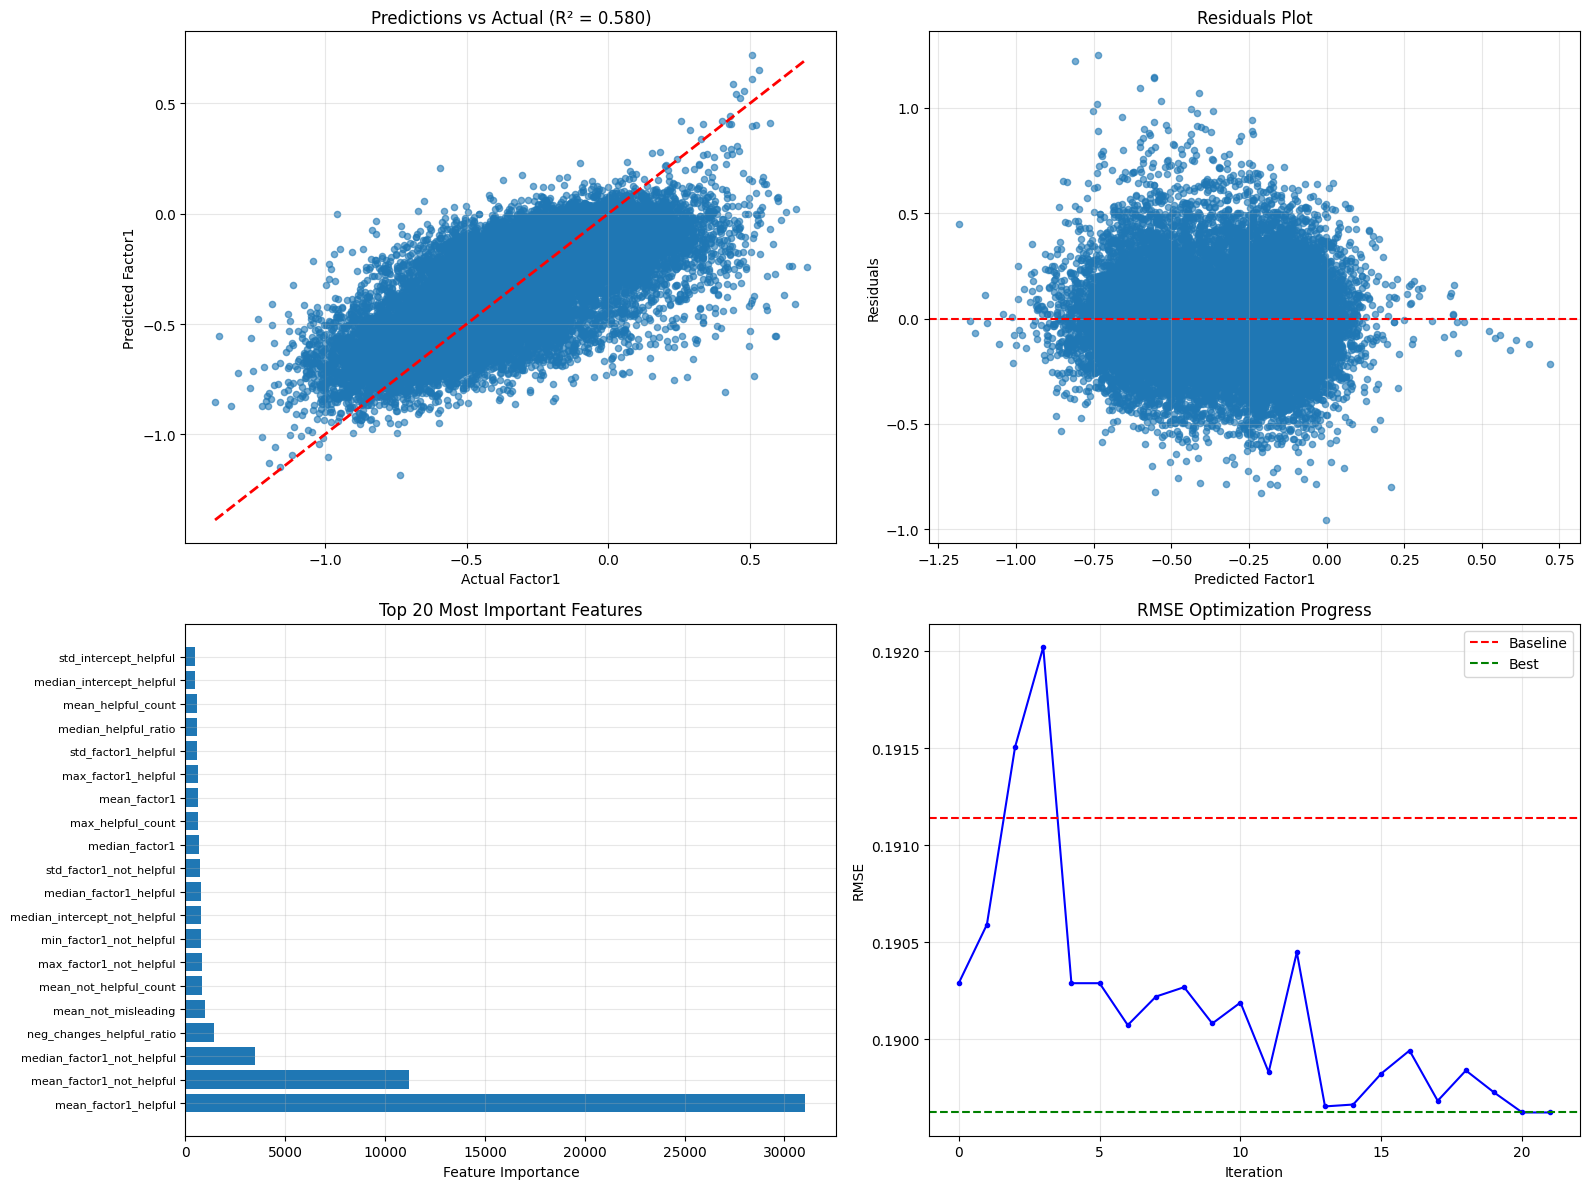


💾 Saving model and results...
📁 Saved files:
  - lightgbm_best_model.pkl
  - lightgbm_best_params.pkl
  - test_predictions.parquet
  - feature_importance.parquet

🏆 Final Model Summary:
Best Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'random_state': 42, 'max_depth': -1, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
Test RMSE: 0.1910
Test R²: 0.5803
Training completed! 🎯


In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

# Load training data
data_dir = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data"
train_data = pd.read_parquet(f"{data_dir}/train_data.parquet")
val_data = pd.read_parquet(f"{data_dir}/val_data.parquet")
test_data = pd.read_parquet(f"{data_dir}/test_data.parquet")

print("🚀 Training LightGBM model with iterative optimization...")
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Prepare datasets
feature_cols = [col for col in train_data.columns if col not in ['userId', 'target_factor1']]
X_train = train_data[feature_cols]
y_train = train_data['target_factor1']
X_val = val_data[feature_cols]
y_val = val_data['target_factor1']
X_test = test_data[feature_cols]
y_test = test_data['target_factor1']

print(f"Number of features: {len(feature_cols)}")
print(f"Target range: [{y_train.min():.3f}, {y_train.max():.3f}]")

# Create LightGBM datasets
train_lgb = lgb.Dataset(X_train, label=y_train)
val_lgb = lgb.Dataset(X_val, label=y_val, reference=train_lgb)

# Baseline model - simple parameters
print("\n🔧 Training baseline model...")
baseline_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

baseline_model = lgb.train(
    baseline_params,
    train_lgb,
    valid_sets=[train_lgb, val_lgb],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

baseline_pred = baseline_model.predict(X_val)
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_pred))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Iterative hyperparameter optimization
best_rmse = baseline_rmse
best_params = baseline_params.copy()
best_model = baseline_model
iteration_results = []

print("\n🎯 Starting iterative hyperparameter optimization...")

# Define parameter ranges to try
param_grids = [
    # Grid 1: Learning rate optimization
    {
        'learning_rate': [0.05, 0.08, 0.12, 0.15],
        'num_leaves': [31],
        'max_depth': [-1]
    },
    # Grid 2: Tree structure optimization
    {
        'learning_rate': [0.1],  # Will update with best from grid 1
        'num_leaves': [15, 31, 63, 127],
        'max_depth': [-1, 6, 8, 10]
    },
    # Grid 3: Regularization optimization
    {
        'learning_rate': [0.1],  # Will update
        'num_leaves': [31],       # Will update
        'max_depth': [-1],        # Will update
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0]
    },
    # Grid 4: Sampling optimization
    {
        'learning_rate': [0.1],   # Will update
        'num_leaves': [31],       # Will update
        'max_depth': [-1],        # Will update
        'feature_fraction': [0.7, 0.8, 0.9, 1.0],
        'bagging_fraction': [0.7, 0.8, 0.9, 1.0]
    }
]

for grid_idx, param_grid in enumerate(param_grids):
    print(f"\n📊 Grid {grid_idx + 1}: Optimizing {list(param_grid.keys())}")
    
    # Update base parameters with current best
    if grid_idx > 0:
        for key in param_grid:
            if key in best_params:
                param_grid[key] = [best_params[key]]
    
    grid_best_rmse = best_rmse
    grid_best_params = None
    
    # Generate all combinations
    import itertools
    keys = param_grid.keys()
    values = param_grid.values()
    
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        
        # Merge with base parameters
        current_params = best_params.copy()
        current_params.update(params)
        
        try:
            # Train model
            model = lgb.train(
                current_params,
                train_lgb,
                valid_sets=[val_lgb],
                valid_names=['val'],
                num_boost_round=1500,
                callbacks=[lgb.early_stopping(80), lgb.log_evaluation(0)]
            )
            
            # Evaluate
            pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred))
            
            # Track results
            iteration_results.append({
                'grid': grid_idx + 1,
                'params': params,
                'rmse': rmse,
                'improvement': best_rmse - rmse
            })
            
            if rmse < grid_best_rmse:
                grid_best_rmse = rmse
                grid_best_params = params
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = current_params.copy()
                    best_model = model
                    print(f"  ✅ New best RMSE: {rmse:.4f} (improvement: {baseline_rmse - rmse:.4f})")
                    
        except Exception as e:
            print(f"  ❌ Error with params {params}: {e}")
            continue
    
    if grid_best_params:
        print(f"  📈 Grid {grid_idx + 1} best: {grid_best_params} -> RMSE: {grid_best_rmse:.4f}")

# Final model evaluation
print(f"\n🎉 Final Results:")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Improvement: {baseline_rmse - best_rmse:.4f} ({((baseline_rmse - best_rmse) / baseline_rmse * 100):.1f}%)")

# Evaluate on test set
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"\n📊 Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R²: {test_r2:.4f}")

# Feature importance analysis
feature_importance = best_model.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predictions vs Actual
axes[0, 0].scatter(y_test, test_pred, alpha=0.6, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Factor1')
axes[0, 0].set_ylabel('Predicted Factor1')
axes[0, 0].set_title(f'Predictions vs Actual (R² = {test_r2:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - test_pred
axes[0, 1].scatter(test_pred, residuals, alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Factor1')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance
top_20_features = importance_df.head(20)
axes[1, 0].barh(range(len(top_20_features)), top_20_features['importance'])
axes[1, 0].set_yticks(range(len(top_20_features)))
axes[1, 0].set_yticklabels(top_20_features['feature'], fontsize=8)
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Top 20 Most Important Features')
axes[1, 0].grid(True, alpha=0.3)

# 4. RMSE improvement over iterations
if iteration_results:
    rmse_values = [r['rmse'] for r in iteration_results]
    axes[1, 1].plot(rmse_values, 'b-o', markersize=3)
    axes[1, 1].axhline(y=baseline_rmse, color='r', linestyle='--', label='Baseline')
    axes[1, 1].axhline(y=best_rmse, color='g', linestyle='--', label='Best')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].set_title('RMSE Optimization Progress')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the best model and results
print(f"\n💾 Saving model and results...")
joblib.dump(best_model, f"{data_dir}/lightgbm_best_model.pkl")
joblib.dump(best_params, f"{data_dir}/lightgbm_best_params.pkl")

# Save predictions and evaluation metrics
results_df = pd.DataFrame({
    'userId': test_data['userId'],
    'actual_factor1': y_test,
    'predicted_factor1': test_pred,
    'residual': residuals
})
results_df.to_parquet(f"{data_dir}/test_predictions.parquet", index=False)

# Save feature importance
importance_df.to_parquet(f"{data_dir}/feature_importance.parquet", index=False)

print(f"📁 Saved files:")
print(f"  - lightgbm_best_model.pkl")
print(f"  - lightgbm_best_params.pkl")
print(f"  - test_predictions.parquet")
print(f"  - feature_importance.parquet")

print(f"\n🏆 Final Model Summary:")
print(f"Best Parameters: {best_params}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training completed! 🎯")

In [9]:
# Quick comparison: Model RMSE vs Target Standard Deviation
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Load test data and predictions
data_dir = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\user_factor_analysis\data"
test_data = pd.read_parquet(f"{data_dir}/test_data.parquet")
results_df = pd.read_parquet(f"{data_dir}/test_predictions.parquet")

# Calculate metrics
target_std = test_data['target_factor1'].std()
model_rmse = np.sqrt(mean_squared_error(results_df['actual_factor1'], results_df['predicted_factor1']))

# Performance ratio
rmse_to_std_ratio = model_rmse / target_std
variance_explained = 1 - (model_rmse**2 / target_std**2)

print("🎯 Model Performance vs Baseline Comparison")
print("=" * 50)
print(f"Target Standard Deviation: {target_std:.4f}")
print(f"Model RMSE:               {model_rmse:.4f}")
print(f"RMSE/StdDev Ratio:        {rmse_to_std_ratio:.4f}")
print(f"Variance Explained:       {variance_explained:.1%}")
print()

if rmse_to_std_ratio < 0.5:
    print("✅ Excellent: RMSE < 50% of target std dev")
elif rmse_to_std_ratio < 0.7:
    print("✅ Good: RMSE < 70% of target std dev")  
elif rmse_to_std_ratio < 1.0:
    print("⚠️  Fair: RMSE < 100% of target std dev")
else:
    print("❌ Poor: RMSE > target std dev (worse than naive prediction)")

print(f"\nInterpretation: Model reduces prediction error by {(1-rmse_to_std_ratio)*100:.1f}% vs naive baseline")

🎯 Model Performance vs Baseline Comparison
Target Standard Deviation: 0.2949
Model RMSE:               0.1910
RMSE/StdDev Ratio:        0.6479
Variance Explained:       58.0%

✅ Good: RMSE < 70% of target std dev

Interpretation: Model reduces prediction error by 35.2% vs naive baseline


In [ ]:
# Quick Spearman correlation between predictions and true Factor1
from scipy.stats import spearmanr

# Compute Spearman correlation
spearman_corr, spearman_p = spearmanr(results_df['actual_factor1'], results_df['predicted_factor1'])

print("\n🔗 Spearman Rank Correlation Analysis")
print("=" * 40)
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"P-value:             {spearman_p:.2e}")
print(f"Significance:        {'Significant' if spearman_p < 0.001 else 'Not significant'} (α = 0.001)")

if spearman_corr > 0.8:
    print("✅ Excellent: Very strong monotonic relationship")
elif spearman_corr > 0.6:
    print("✅ Good: Strong monotonic relationship")
elif spearman_corr > 0.4:
    print("⚠️  Fair: Moderate monotonic relationship")
else:
    print("❌ Poor: Weak monotonic relationship")

print(f"\nInterpretation: Model captures {spearman_corr**2:.1%} of the rank-order variance in Factor1")